In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
players1 = pd.read_csv("phs_2020_1.csv")
players2 = pd.read_csv("phs_2020_2.csv")
combine = [players1, players2]
data = pd.concat(combine).drop(['start_time'], axis=1)
data.drop(data.index[data['tournament_title'] != 'OWL 2020 Regular Season'], inplace=True)
data.drop(['tournament_title'], axis = 1, inplace = True)
cols = ['esports_match_id', 'map_type', 'map_name', 'player_name', 'team_name', 'hero_name', 'stat_name', 'stat_amount']
data = data.reindex(columns = cols)
data = data[data["hero_name"] != "All Heroes"]
stats = ['Hero Damage Done', 'Assists', 'Barrier Damage Done', 'Deaths', 'Eliminations', 'Objective Kills', 'Objective Time', 'Ultimates Earned - Fractional', 'Final Blows', 'Damage Blocked', 'Healing Done']
data = data.loc[data['stat_name'].isin(stats)]
data['stat_amount'] = data['stat_amount'].round(decimals = 2)

# Tidy dataset to elongate stat_name column into rows and insert respective stat_amount values
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']].copy().reset_index()
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']]
data = data.pivot_table(values='stat_amount', index=[data['esports_match_id'],data['team_name'], data['player_name'], data['map_name'], data['hero_name']], columns='stat_name', aggfunc='sum')
data = data.fillna(0)
data = data.reset_index()
data.rename(columns = {'Ultimates Earned - Fractional':'Ultimates Earned'}, inplace = True)
print(data['esports_match_id'].max())
print(data['esports_match_id'].min())
data['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
data

35554
30991


stat_name,esports_match_id,team_name,player_name,map_name,hero_name,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24946,35554,Seoul Dynasty,Profit,Temple of Anubis,Pharah,0.0,0.00,0.00,1.0,1.0,1.0,0.00,883.85,0.0,0.00,0.63
24947,35554,Seoul Dynasty,tobi,Busan,Mercy,1.0,30.00,0.00,2.0,3.0,2.0,6772.00,200.00,0.0,8.23,3.85
24948,35554,Seoul Dynasty,tobi,Kings Row,Mercy,1.0,20.00,0.00,1.0,2.0,1.0,9917.83,407.64,1.0,41.80,5.33
24949,35554,Seoul Dynasty,tobi,Temple of Anubis,Lúcio,1.0,20.00,0.00,0.0,2.0,1.0,295.03,552.82,1.0,18.45,0.35


In [56]:
maps = pd.read_csv("match_map_stats.csv")
maps['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
maps.head(10)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,Los Angeles Valiant,San Francisco Shock,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,Los Angeles Valiant,San Francisco Shock,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2
5,2018-01-11 00:51:16,2018-01-11 00:56:55,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,4,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,0.000000,36.396057,NaN,NaN,3,4
6,2018-01-11 01:11:32,2018-01-11 01:16:33,Overwatch League - Stage 1,10223,3,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Ilios,1,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,1
7,2018-01-11 01:17:19,2018-01-11 01:20:09,Overwatch League - Stage 1,10223,3,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Ilios,2,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,100.0,0.0,1,1
8,2018-01-11 01:20:55,2018-01-11 01:25:08,Overwatch League - Stage 1,10223,3,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Ilios,3,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,100.0,65.0,2,1
9,2018-01-11 01:32:26,2018-01-11 01:39:37,Overwatch League - Stage 1,10223,4,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Numbani,1,...,Los Angeles Valiant,San Francisco Shock,75.549507,0.000000,0.000000,0.000000,NaN,NaN,1,0


In [57]:
maps['map_name'].unique()

array(['Dorado', 'Temple of Anubis', 'Ilios', 'Numbani', 'Eichenwalde',
       'Junkertown', 'Oasis', 'Horizon Lunar Colony', 'Lijiang Tower',
       'Volskaya Industries', 'Nepal', 'Kings Row', 'Route 66',
       'Hollywood', 'Hanamura', 'Watchpoint: Gibraltar', 'Blizzard World',
       'Rialto', 'Busan', 'Paris', 'Havana'], dtype=object)

In [58]:
cleaned_maps = pd.DataFrame()
maps.query("`match_id` >= 30991", inplace = True)
maps.query("`match_id` <= 36231", inplace = True)
cleaned_maps['match_id'] = maps['match_id']
cleaned_maps['team_one'] = maps['team_one_name']
cleaned_maps['team_two'] = maps['team_two_name']
cleaned_maps['map_winner'] = maps['map_winner']
cleaned_maps['map_name'] = maps['map_name']
cleaned_maps['game_number'] = maps['game_number']
cleaned_maps['match_winner'] = maps['match_winner']
cleaned_maps.drop_duplicates(inplace = True)
cleaned_maps


,match_id,team_one,team_two,map_winner,map_name,game_number,match_winner
6246,30991,Toronto Defiant,Paris Eternal,Paris Eternal,Lijiang Tower,1,Toronto Defiant
6248,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Eichenwalde,2,Toronto Defiant
6252,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Horizon Lunar Colony,3,Toronto Defiant
6255,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Havana,4,Toronto Defiant
6257,30992,London Spitfire,New York Excelsior,London Spitfire,Lijiang Tower,1,New York Excelsior
...,...,...,...,...,...,...,...
9071,35552,Seoul Dynasty,San Francisco Shock,San Francisco Shock,Kings Row,2,San Francisco Shock
9073,35552,San Francisco Shock,Seoul Dynasty,Seoul Dynasty,Hanamura,3,San Francisco Shock
9075,35552,San Francisco Shock,Seoul Dynasty,Seoul Dynasty,Watchpoint: Gibraltar,4,San Francisco Shock
9077,35552,Seoul Dynasty,San Francisco Shock,San Francisco Shock,Busan,5,San Francisco Shock


In [59]:
new_frame = pd.DataFrame(columns = cleaned_maps.columns)
for index, row in cleaned_maps.iterrows():
    if row['team_two'] < row['team_one']:
        new_frame.loc[index] = [row['match_id'], row['team_two'], row['team_one'], row['map_winner'], row['map_name'], row['game_number'], row['match_winner']]
    else:
        new_frame.loc[index] = [row['match_id'], row['team_one'], row['team_two'], row['map_winner'], row['map_name'], row['game_number'], row['match_winner']]
cleaned_maps = new_frame
cleaned_maps      

,match_id,team_one,team_two,map_winner,map_name,game_number,match_winner
6246,30991,Paris Eternal,Toronto Defiant,Paris Eternal,Lijiang Tower,1,Toronto Defiant
6248,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Eichenwalde,2,Toronto Defiant
6252,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Horizon Lunar Colony,3,Toronto Defiant
6255,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Havana,4,Toronto Defiant
6257,30992,London Spitfire,New York Excelsior,London Spitfire,Lijiang Tower,1,New York Excelsior
...,...,...,...,...,...,...,...
9071,35552,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Kings Row,2,San Francisco Shock
9073,35552,San Francisco Shock,Seoul Dynasty,Seoul Dynasty,Hanamura,3,San Francisco Shock
9075,35552,San Francisco Shock,Seoul Dynasty,Seoul Dynasty,Watchpoint: Gibraltar,4,San Francisco Shock
9077,35552,San Francisco Shock,Seoul Dynasty,San Francisco Shock,Busan,5,San Francisco Shock


In [60]:

win_perc = pd.DataFrame(columns = ['map_name', 'team', 'wins', 'games_played'])
win_dict = {}
played_dict = {}
for val in cleaned_maps['team_one'].unique():
    win_dict[val] = 0
    played_dict[val] = 0
for name in cleaned_maps['map_name'].unique():
    temp_pd = pd.DataFrame()
    team = cleaned_maps.query("`map_name` == '{}'".format(name))
    for index, row in team.iterrows():
        if (row['map_winner'] != 'draw'):
            played_dict[row['team_one']] = played_dict.get(row['team_one'],0) + 1
            played_dict[row['team_two']] = played_dict.get(row['team_two'],0) + 1
            if (row['team_one'] == row['map_winner']):
                win_dict[row['team_one']] = win_dict.get(row['team_one'],0) + 1
            else:
                win_dict[row['team_two']] = win_dict.get(row['team_one'],0) + 1
    for team_name in cleaned_maps['team_one'].unique():
        temp_dict = {'map_name': name, 'team': team_name, 'wins': win_dict.get(team_name, 0), 'games_played': played_dict.get(team_name, 0)}
        win_perc = win_perc.append(temp_dict, ignore_index = True)
    win_dict = {}
    played_dict = {}
    for val in cleaned_maps['team_one'].unique():
        win_dict[val] = 0
        played_dict[val] = 0
win_perc

,map_name,team,wins,games_played
0,Lijiang Tower,Paris Eternal,6,10
1,Lijiang Tower,London Spitfire,1,6
2,Lijiang Tower,Los Angeles Gladiators,5,13
3,Lijiang Tower,Dallas Fuel,3,7
4,Lijiang Tower,Boston Uprising,3,9
...,...,...,...,...
373,Watchpoint: Gibraltar,Toronto Defiant,1,3
374,Watchpoint: Gibraltar,Hangzhou Spark,5,5
375,Watchpoint: Gibraltar,Seoul Dynasty,5,8
376,Watchpoint: Gibraltar,Vancouver Titans,2,5


In [61]:
win_perc['games_played'].replace({0: np.nan}, inplace = True)
win_perc['win_perc'] = win_perc['wins'] / win_perc['games_played']
win_perc

,map_name,team,wins,games_played,win_perc
0,Lijiang Tower,Paris Eternal,6,10.0,0.6
1,Lijiang Tower,London Spitfire,1,6.0,0.166667
2,Lijiang Tower,Los Angeles Gladiators,5,13.0,0.384615
3,Lijiang Tower,Dallas Fuel,3,7.0,0.428571
4,Lijiang Tower,Boston Uprising,3,9.0,0.333333
...,...,...,...,...,...
373,Watchpoint: Gibraltar,Toronto Defiant,1,3.0,0.333333
374,Watchpoint: Gibraltar,Hangzhou Spark,5,5.0,1.0
375,Watchpoint: Gibraltar,Seoul Dynasty,5,8.0,0.625
376,Watchpoint: Gibraltar,Vancouver Titans,2,5.0,0.4


In [62]:
data

stat_name,esports_match_id,team_name,player_name,map_name,hero_name,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24946,35554,Seoul Dynasty,Profit,Temple of Anubis,Pharah,0.0,0.00,0.00,1.0,1.0,1.0,0.00,883.85,0.0,0.00,0.63
24947,35554,Seoul Dynasty,tobi,Busan,Mercy,1.0,30.00,0.00,2.0,3.0,2.0,6772.00,200.00,0.0,8.23,3.85
24948,35554,Seoul Dynasty,tobi,Kings Row,Mercy,1.0,20.00,0.00,1.0,2.0,1.0,9917.83,407.64,1.0,41.80,5.33
24949,35554,Seoul Dynasty,tobi,Temple of Anubis,Lúcio,1.0,20.00,0.00,0.0,2.0,1.0,295.03,552.82,1.0,18.45,0.35


In [63]:
map_list = data['map_name'].unique()
pick_rate = {}

for name in map_list:
    # Initialized dictionary of map pick rate per 
    map_rate = {}
    for val in data['hero_name'].unique():
        map_rate[val] = 0
    for index, row in data.iterrows():
        #row[3] is map, and row[4] is hero
        if row[3] == name:
            map_rate[row[4]] = map_rate[row[4]] + 1
    pick_rate[name] = map_rate

['Eichenwalde' 'Havana' 'Horizon Lunar Colony' 'Lijiang Tower'
 'Junkertown' 'Kings Row' 'Dorado' 'Hanamura' 'Nepal' 'Blizzard World'
 'Oasis' 'Temple of Anubis' 'Busan' 'Ilios' 'Numbani' 'Paris' 'Route 66'
 'Volskaya Industries' 'Hollywood' 'Rialto' 'Watchpoint: Gibraltar']


KeyError: 0

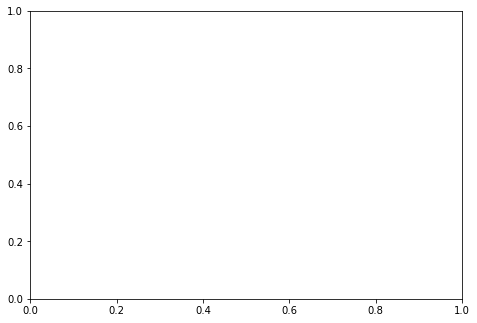

In [64]:
print(map_list)
control_maps = ['Ilios', 'Lijiang Tower', 'Nepal', 'Oasis']
assault_maps = ['Hanamura', 'Horizon Lunar Colony', 'Temple of Anubis', 'Volskaya Industries']
escort_maps = ['Dorado', 'Havana', 'Junkertown', 'Rialto', 'Route 66', 'Watchpoint: Gibraltar']
hybrid_maps = ['Blizzard World', 'Hollywood', 'Kings Row', 'Numbani']
mode_list = [control_maps, assault_maps, escort_maps, hybrid_maps]
for mode in mode_list:
    X = np.arange(4)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
    ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
    ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)